In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from math import pow
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

In [2]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [3]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [4]:
####################### read in sales record file (training set) ################################
# first, function to parse date string to datetime
parser_todate1 = lambda date: pd.to_datetime(date, format = '%d.%m.%Y')

df_sales = pd.read_csv('data/sales_train.csv', parse_dates=['date'], date_parser=parser_todate1)

In [5]:
#look at sales data
print (df_sales.shape)
df_sales.head (10)

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
6,2013-01-02,0,25,2565,549.00,1.0
7,2013-01-04,0,25,2572,239.00,1.0
8,2013-01-11,0,25,2572,299.00,1.0
9,2013-01-03,0,25,2573,299.00,3.0


In [6]:
df_sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [7]:
df_sales.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object

In [8]:
#check for null
df_sales.isnull().sum().sort_values(ascending=False)

item_cnt_day      0
item_price        0
item_id           0
shop_id           0
date_block_num    0
date              0
dtype: int64

In [9]:
##########################read in other data file and join with df_sales #####################
    
    # 1.items.csv to get item_category_id; 

df_iteminfo = pd.read_csv('data/items.csv')
print (df_iteminfo.shape)
df_iteminfo.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
#read in other data file to join with df_sales 
    
    # 2.sup/item_category.csv to get translated item names and category names (original is in Russian; source: deargle and Kâzım Anıl Eren) )

df_itemtln = pd.read_csv('data/sup/item_category.csv')
print (df_itemtln.shape)
df_itemtln.head()

(22170, 4)


,item_id,item_name_translated,item_cat1,item_cat2
0,5441,PC: Headset HyperX Cloud Core gaming stereo (K...,PC,Headsets / Headphones
1,16255,Headphones PHILIPS SBC HC8680,PC,Headsets / Headphones
2,16256,Headphones RITMIX RH-120,PC,Headsets / Headphones
3,16257,Headphones RITMIX RH-124 Black,PC,Headsets / Headphones
4,5606,PS2: Memory Card 8 MB Black (Memory Card 8Mb -...,Accessories,PS2


In [11]:
#left join df_itemtln and df_iteminfo to get item_category_id from df_iteminfo (before joining to the main df_sales)
df_itemtln = pd.merge(df_itemtln, df_iteminfo[['item_id','item_category_id']], how = 'left', left_on = 'item_id', right_on = 'item_id')
df_itemtln.head()
  

,item_id,item_name_translated,item_cat1,item_cat2,item_category_id
0,5441,PC: Headset HyperX Cloud Core gaming stereo (K...,PC,Headsets / Headphones,0
1,16255,Headphones PHILIPS SBC HC8680,PC,Headsets / Headphones,0
2,16256,Headphones RITMIX RH-120,PC,Headsets / Headphones,0
3,16257,Headphones RITMIX RH-124 Black,PC,Headsets / Headphones,0
4,5606,PS2: Memory Card 8 MB Black (Memory Card 8Mb -...,Accessories,PS2,1


In [12]:
#check if translated item and category info have nulls
df_itemtln.isnull().sum().sort_values(ascending=False)   

item_cat2               58
item_category_id         0
item_cat1                0
item_name_translated     0
item_id                  0
dtype: int64

In [13]:
#left join df_sales and df_itemtln to add item and category name/id to the main sales records
df_sales = pd.merge(df_sales, df_itemtln, how ='left', left_on = 'item_id', right_on = 'item_id')
df_sales.isnull().sum().sort_values(ascending=False)  

item_cat2               30403
item_category_id            0
item_cat1                   0
item_name_translated        0
item_cnt_day                0
item_price                  0
item_id                     0
shop_id                     0
date_block_num              0
date                        0
dtype: int64

In [14]:
print(df_sales.shape)

(2935849, 10)


In [14]:
#read in other data file to join with df_sales 
    # 3.calendar.csv to get weekend and holiday info for dates (source: Kâzım Anıl Eren)
parser_todate2 = lambda date: pd.to_datetime(date, format = '%Y-%m-%d')

df_calendar = pd.read_csv('data/sup/calendar.csv', parse_dates=['date'], date_parser=parser_todate2)
df_calendar.head()

,date,holiday,weekend
0,2013-01-01,1,0
1,2013-01-02,1,0
2,2013-01-03,1,0
3,2013-01-04,1,0
4,2013-01-05,0,1


In [15]:
#check for null values
df_calendar.isnull().sum().sort_values(ascending=False)  

weekend    0
holiday    0
date       0
dtype: int64

In [16]:
#get month/year/day_of_week to investiagte trend
df_calendar['month'] = df_calendar.date.apply(lambda x: x.strftime('%m'))
df_calendar['year'] = df_calendar.date.apply(lambda x: x.strftime('%Y'))
df_calendar['day_of_week'] = df_calendar.date.apply(lambda x: x.weekday())                

In [17]:
#read in other data file, join data by fields 
    #  4.translated shop info: shop name, type and city (original in Russian; source: Kâzım Anıl Eren)
df_shop = pd.read_csv('data/sup/shops-translated.csv')
df_shop.head()

,shop_id,City,Type,Name
0,0,Yakutsk,Shop,"Ordzhonikidze, 56 francs"
1,1,Yakutsk,TC,Central franc
2,2,Adygea,TC,Mega
3,3,Balashikha,TRC,October-Kinomir
4,4,Volzhsky,TC,Volga Mall


In [18]:
#check for null
df_shop.isnull().sum().sort_values(ascending=False)  

Name       1
Type       0
City       0
shop_id    0
dtype: int64

In [19]:
#join addition data frames with df_sales
df_sales = pd.merge(df_sales, df_calendar, how = 'left', left_on = 'date', right_on = 'date')
df_sales = pd.merge(df_sales, df_shop, how = 'left', left_on = 'shop_id', right_on = 'shop_id')
df_sales.head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_cat1,item_cat2,item_category_id,holiday,weekend,month,year,day_of_week,City,Type,Name
0,2013-01-02,0,59,22154,999.00,1.0,SCENE 2012 (BD),Cinema,Blu-Ray,37,1,0,01,2013,2,Yaroslavl,SC,Altair
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,Music,Vinyl,58,1,0,01,2013,3,Moscow,TRC,Atrium
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,Music,Vinyl,58,0,1,01,2013,5,Moscow,TRC,Atrium
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,Music,Vinyl,58,0,1,01,2013,6,Moscow,TRC,Atrium
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),Music,CD of branded production,56,0,0,01,2013,1,Moscow,TRC,Atrium


In [20]:
#check for null values in the joined data frame
df_sales.isnull().sum().sort_values(ascending=False) 

item_cat2               30403
Name                     3751
City                        0
day_of_week                 0
year                        0
month                       0
weekend                     0
holiday                     0
item_category_id            0
Type                        0
item_cat1                   0
item_name_translated        0
item_cnt_day                0
item_price                  0
item_id                     0
shop_id                     0
date_block_num              0
date                        0
dtype: int64

In [21]:
#check for data types
df_sales.dtypes

date                    datetime64[ns]
date_block_num                   int64
shop_id                          int64
item_id                          int64
item_price                     float64
item_cnt_day                   float64
item_name_translated            object
item_cat1                       object
item_cat2                       object
item_category_id                 int64
holiday                          int64
weekend                          int64
month                           object
year                            object
day_of_week                      int64
City                            object
Type                            object
Name                            object
dtype: object

In [22]:
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_cat1,item_cat2,item_category_id,holiday,weekend,month,year,day_of_week,City,Type,Name
0,2013-01-02,0,59,22154,999.00,1.0,SCENE 2012 (BD),Cinema,Blu-Ray,37,1,0,01,2013,2,Yaroslavl,SC,Altair
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,Music,Vinyl,58,1,0,01,2013,3,Moscow,TRC,Atrium
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,Music,Vinyl,58,0,1,01,2013,5,Moscow,TRC,Atrium
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,Music,Vinyl,58,0,1,01,2013,6,Moscow,TRC,Atrium
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),Music,CD of branded production,56,0,0,01,2013,1,Moscow,TRC,Atrium


In [23]:
#get date and block numbers (month)in the training set
print('earliest date in training set = %s' % df_sales['date'].min())
print('latest date in training set = %s' % df_sales['date'].max())

print('date block numbers = %s' % df_sales['date_block_num'].unique())
#df_sales[df_sales['date_block_num'] == 20]['date'].min()

earliest date in training set = 2013-01-01 00:00:00
latest date in training set = 2015-10-31 00:00:00
date block numbers = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


In [24]:
################### read in test set and screen for overlaps of store id's before analysis #######
df_test = pd.read_csv('data/test.csv')
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [25]:
#check for null values in test set
df_test.isnull().sum().sort_values(ascending=False)

item_id    0
shop_id    0
ID         0
dtype: int64

In [26]:
#screen for overlaps of item_id/shop_id between train and test set
print ("number in training set (original) = ", df_sales.shape[0])
print ("number in test set (original) = ", df_test.shape[0])
test_shopID = df_test.shop_id.unique()
test_itemID = df_test.item_id.unique()

df_sales = df_sales[df_sales.shop_id.isin(test_shopID)]
df_sales = df_sales[df_sales.item_id.isin(test_itemID)]

print ("number in training set (screened) = ", df_sales.shape[0])


number in training set (original) =  2935849
number in test set (original) =  214200
number in training set (screened) =  1224439


[Text(33.0, 0.5, 'Store'), Text(0.5, 15.0, 'Month')]

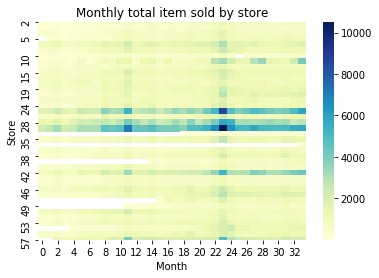

In [27]:
################ Exploratory Data Analysis ###################################################

#plot monthly total item sold by store
sales_by_store = df_sales.pivot_table(index='shop_id', columns='date_block_num', \
                                      values='item_cnt_day', aggfunc='sum')

ax=sns.heatmap(sales_by_store,cmap="YlGnBu")
ax.set_title("Monthly total item sold by store")
ax.set(xlabel='Month',ylabel='Store')

In [28]:
#compute revenue
df_sales['revenue'] = df_sales['item_cnt_day'] * df_sales['item_price']

[Text(33.0, 0.5, 'Store'), Text(0.5, 15.0, 'Month')]

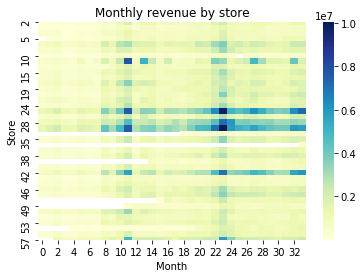

In [29]:
#plot total monthly revenue for each store
revenue_by_store = df_sales.pivot_table(index='shop_id', columns='date_block_num', \
                                        values='revenue', aggfunc='sum')

ax = sns.heatmap(revenue_by_store,cmap="YlGnBu")
ax.set_title("Monthly revenue by store")
ax.set(xlabel='Month',ylabel='Store')


In [30]:
#get daily sales df (for further daily pattern analysis)
df_dailysales = df_sales

df_dailysales = df_dailysales.sort_values('date').groupby(['date', 'shop_id'], as_index=False)
df_dailysales = df_dailysales.agg({'revenue':['sum'], 'item_cnt_day':['sum']})

df_dailysales.columns = ['date', 'shop_id', 'sum_revenue', 'sum_item_cnt']


df_dailysales = pd.merge(df_dailysales, df_calendar, how = 'left', left_on = 'date', right_on = 'date')
df_dailysales = pd.merge(df_dailysales, df_shop, how = 'left', left_on = 'shop_id', right_on = 'shop_id')

df_dailysales.head()


,date,shop_id,sum_revenue,sum_item_cnt,holiday,weekend,month,year,day_of_week,City,Type,Name
0,2013-01-01,2,1496.0,4.0,1,0,01,2013,1,Adygea,TC,Mega
1,2013-01-01,7,13912.3,19.0,1,0,01,2013,1,Voronezh,TRC,Maksimir
2,2013-01-01,14,16489.0,22.0,1,0,01,2013,1,Kazan,TC,ParkHaus II
3,2013-01-01,15,22442.5,30.0,1,0,01,2013,1,Kaluga,TRC,XXI Century
4,2013-01-01,18,15055.0,16.0,1,0,01,2013,1,Krasnoyarsk,TC,June


[Text(33.0, 0.5, 'Store'), Text(0.5, 15.0, 'Day of the week')]

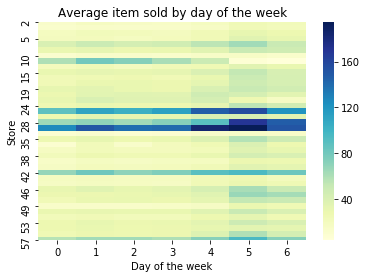

In [31]:
#plot average daily sales for each day of week
df_dailysales['day_of_week'] = df_dailysales.date.apply(lambda x: x.weekday())
dofwsales_by_store = df_dailysales.pivot_table(index='shop_id', columns='day_of_week', \
                                               values='sum_item_cnt', aggfunc='mean')

ax=sns.heatmap(dofwsales_by_store,cmap="YlGnBu")
ax.set_title("Average item sold by day of the week")
ax.set(xlabel='Day of the week',ylabel='Store')


[Text(33.0, 0.5, 'Store'), Text(0.5, 15.0, 'Holiday')]

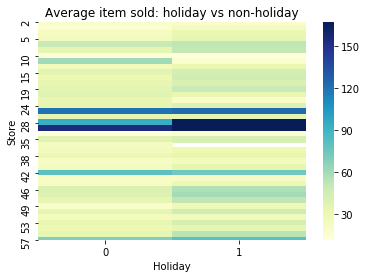

In [32]:
#plot avearage daily sales (item count) on holiday vs. non-holiday
holidaysales_by_store = df_dailysales.pivot_table(index='shop_id', columns='holiday', values='sum_item_cnt', aggfunc='mean')
 
ax=sns.heatmap(holidaysales_by_store,cmap="YlGnBu")
ax.set_title("Average item sold: holiday vs non-holiday")
ax.set(xlabel='Holiday',ylabel='Store')


[Text(33.0, 0.5, 'Store'), Text(0.5, 15.0, 'Holiday')]

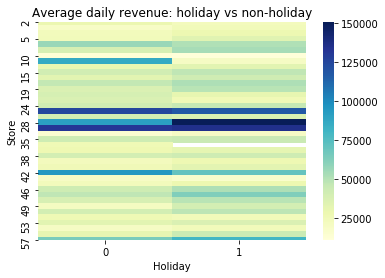

In [33]:
# plot average daily revnue on holiday vs. non-holiday
holidayrevenue_by_store = df_dailysales.pivot_table(index='shop_id', columns='holiday', values='sum_revenue', aggfunc='mean')
 
ax=sns.heatmap(holidayrevenue_by_store,cmap="YlGnBu")
ax.set_title("Average daily revenue: holiday vs non-holiday")
ax.set(xlabel='Holiday',ylabel='Store')


[Text(33.0, 0.5, 'Store'), Text(0.5, 15.0, 'Weekend')]

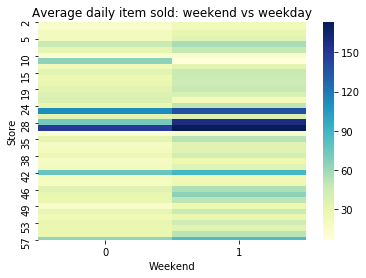

In [34]:
#plot average daily sales (item counts) on weekend vs weekdays
wkndsales_by_store = df_dailysales.pivot_table(index='shop_id', columns='weekend', values='sum_item_cnt', aggfunc='mean')

ax= sns.heatmap(wkndsales_by_store,cmap="YlGnBu")
ax.set_title("Average daily item sold: weekend vs weekday")
ax.set(xlabel='Weekend',ylabel='Store')


[Text(33.0, 0.5, 'Store'), Text(0.5, 15.0, 'Weekend')]

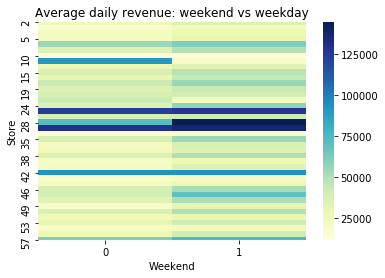

In [35]:
#plot Average daily revenue on weekend vs. weekdays 
wkndrevenue_by_store = df_dailysales.pivot_table(index='shop_id', columns='weekend', values='sum_revenue', aggfunc='mean')

ax=sns.heatmap(wkndrevenue_by_store,cmap="YlGnBu")
ax.set_title("Average daily revenue: weekend vs weekday")
ax.set(xlabel='Weekend',ylabel='Store')


In [36]:
# get price history (discount)
df_pricehist = df_sales.groupby(['shop_id','item_id'],\
                                as_index=False).agg({'item_price':[np.min,np.max,np.median]})
df_pricehist.columns = ['shop_id','item_id','item_price_min','item_price_max','item_price_median']


df_sales = pd.merge(df_sales, df_pricehist, left_on=['item_id','shop_id'], \
                    right_on=['item_id','shop_id'], how='left')

In [ ]:
################ feature engineering ##########################################################

In [ ]:
########### feature (for each store)
# average monthly total sale 
# avg. monthly sale by category
# past month sale by item(?) (M-1; M-2; M-3; M-12)
# past month sale by category(?) (M-1; M-2; M-3; M-12)
# %price (due to discount) 
# number of holidays

In [37]:
# create monthly sales data frame (to use in model building)
df_monthlysales = df_sales.groupby(['shop_id','item_id','date_block_num'], as_index=False).agg({'item_cnt_day':['sum','mean'],'item_price':[np.median],'revenue':['sum']})
df_monthlysales.columns = ['shop_id','item_id','date_block_num','monthsum_item_cnt','monthmean_item_cnt','monthmedian_item_price','monthsum_revenue']

In [38]:
# get price change from previous month (median)
previous_month = [1, 2, 3]

for m in previous_month:
    feature = ('m-%s_monthsum_item_cnt' % m)
    df_monthlysales[feature] = df_monthlysales.sort_values('date_block_num').groupby(['shop_id','item_id'])['monthsum_item_cnt'].shift(m)
    df_monthlysales[feature].fillna(0, inplace=True)

df_monthlysales['medianprice_dif_m-1'] = df_monthlysales['monthmedian_item_price']
df_monthlysales['medianprice_dif_m-1'] -= df_monthlysales.sort_values('date_block_num').groupby(['shop_id','item_id'])['monthmedian_item_price'].shift(1)
df_monthlysales['medianprice_dif_m-1'].fillna(0, inplace=True)

In [39]:
df_monthlysales.head()

,shop_id,item_id,date_block_num,monthsum_item_cnt,monthmean_item_cnt,monthmedian_item_price,monthsum_revenue,m-1_monthsum_item_cnt,m-2_monthsum_item_cnt,m-3_monthsum_item_cnt,medianprice_dif_m-1
0,2,30,2,1.0,1.0,359.0,359.0,0.0,0.0,0.0,0.0
1,2,30,5,1.0,1.0,399.0,399.0,1.0,0.0,0.0,40.0
2,2,30,15,1.0,1.0,169.0,169.0,1.0,1.0,0.0,-230.0
3,2,30,16,1.0,1.0,169.0,169.0,1.0,1.0,1.0,0.0
4,2,31,1,4.0,1.0,699.0,2796.0,0.0,0.0,0.0,0.0


In [40]:
# add monthly total sales (item_cnt/revenue)
df_monthlyshopsales = df_monthlysales.groupby(['shop_id','date_block_num'], \
                                              as_index=False).agg({'monthsum_item_cnt':['sum'],'monthsum_revenue':['sum']})
df_monthlyshopsales.columns = ['shop_id','date_block_num','monthsum_totalitem_cnt','monthsum_totalrevenue']

df_monthlysales = pd.merge(df_monthlysales, df_monthlyshopsales, how='left', \
                           on = ['shop_id','date_block_num'])


In [41]:
# add number of total/holiday/weekend days in each month (date_block_num) 
df_daycount = df_calendar.groupby(['year','month'], as_index=False\
                                 ).agg({'date':['count'], 'holiday':['sum'],'weekend':['sum']})
df_daycount.columns = ['year', 'month', 'numdays', 'numholidays','numweekends']

df_daycount = pd.merge(df_daycount, df_sales[['year','month','date_block_num']], how='inner', \
                       on = ['year','month'])
df_daycount = df_daycount.drop_duplicates().reset_index(drop=True)
df_monthlysales = pd.merge(df_monthlysales, \
                           df_daycount[['date_block_num','numdays','numholidays','numweekends','year','month']],\
                           how ='left', on = 'date_block_num')

In [42]:
# add item category info and shop info to df_monthlysales (before one hot encoding)
df_monthlysales = pd.merge(df_monthlysales, df_itemtln[['item_id','item_category_id','item_cat1','item_cat2']],\
                           how='left', on='item_id')
df_monthlysales = pd.merge(df_monthlysales, df_shop[['shop_id','City','Type']], how='left', \
                           on='shop_id')


In [43]:
# one hot encoding for (item_category_id, item_cat1, item_cat2, City, Type, month, year) 
for col in ['year','month','item_category_id','item_cat1','item_cat2','City','Type'] :
    df_monthlysales[col] = pd.Categorical(df_monthlysales[col])
    df_dummy = pd.get_dummies(df_monthlysales[col], prefix = col)
    df_monthlysales = pd.concat([df_monthlysales, df_dummy], axis=1)


In [44]:
#clean up monthlysales data frame (drop columns)
df_monthlysales = df_monthlysales.drop(['year','month','item_category_id','item_cat1','item_cat2','City','Type'], axis=1)
print(df_monthlysales.shape)

(600159, 185)


In [45]:
df_monthlysales['date_block_num'].max()

33

In [46]:
####################### model training, valudation, and prediction #############################

# get training, validation set, and test set
X_train = df_monthlysales[df_monthlysales['date_block_num'] < 31].drop(['monthsum_item_cnt',], axis=1)
Y_train = df_monthlysales[df_monthlysales['date_block_num'] < 31]['monthsum_item_cnt']
X_valid = df_monthlysales[df_monthlysales['date_block_num'] == 31].drop(['monthsum_item_cnt'], axis=1)
Y_valid = df_monthlysales[df_monthlysales['date_block_num'] == 31]['monthsum_item_cnt']
X_test = df_monthlysales[df_monthlysales['date_block_num'] == 32].drop(['monthsum_item_cnt'], axis=1)


In [48]:
# build model using XGBRegressor

model = xgb.XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)


[0]	validation_0-rmse:9.79177	validation_1-rmse:4.49475
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:8.45399	validation_1-rmse:3.51925
[2]	validation_0-rmse:7.69524	validation_1-rmse:3.07237
[3]	validation_0-rmse:7.12267	validation_1-rmse:2.58189
[4]	validation_0-rmse:6.76317	validation_1-rmse:2.27522
[5]	validation_0-rmse:6.49707	validation_1-rmse:2.13270
[6]	validation_0-rmse:6.37041	validation_1-rmse:2.02310
[7]	validation_0-rmse:6.20095	validation_1-rmse:2.02153
[8]	validation_0-rmse:6.07964	validation_1-rmse:2.07917
[9]	validation_0-rmse:5.99486	validation_1-rmse:2.15732
[10]	validation_0-rmse:5.80559	validation_1-rmse:2.05369
[11]	validation_0-rmse:5.71198	validation_1-rmse:2.01800
[12]	validation_0-rmse:5.62524	validation_1-rmse:2.03839
[13]	validation_0-rmse:5.59978	validation_1-rmse:1.99550
[14]	validation_0-rmse:5.55068	validation_1-rmse:1.93

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

In [49]:
# compute predicted sales for valudation set
Y_pred = model.predict(X_valid)

Text(0.5, 1.0, 'Validation set prediction vs actual values')

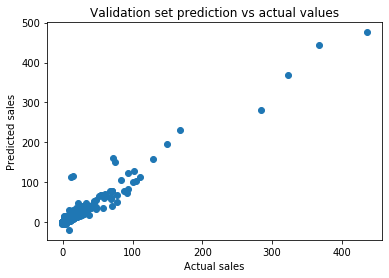

In [50]:
#plot predicted value vs actual sales value for validation set
plt.scatter(Y_valid, Y_pred)
plt.xlabel('Actual sales')
plt.ylabel('Predicted sales')
plt.title('Validation set prediction vs actual values')
#plt.scatter(Y_valid[Y_valid<=20], Y_pred[Y_valid<=20])

In [51]:
#compute root mean square error for validation set
rms_valid = sqrt(mean_squared_error(Y_valid, Y_pred))
rms_valid

1.564309669744066

In [52]:
#compute prediction for test set
Y_submission = model.predict(X_test)


Text(0.5, 1.0, 'Test set prediction vs actual values')

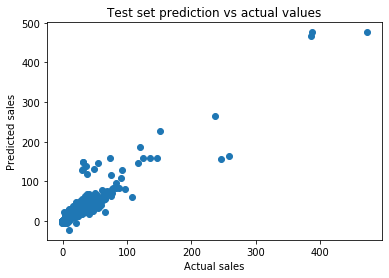

In [53]:
#plot predicted values vs. actual sales values for test set
Y_test = df_monthlysales[df_monthlysales['date_block_num'] == 32]['monthsum_item_cnt']
plt.scatter(Y_test, Y_submission)
plt.xlabel('Actual sales')
plt.ylabel('Predicted sales')
plt.title('Test set prediction vs actual values')

In [54]:
#compute root mean square error for test set prediction
rms_submission = sqrt(mean_squared_error(Y_test, Y_submission))
rms_submission

2.5252566391260767